In [1]:
import subprocess
import os
import shutil
import warnings

warnings.filterwarnings("ignore")
from ast import literal_eval
import itertools
import matplotlib.pyplot as plt
import toolsets.spectra_operations as so
import seaborn as sns
from tqdm import tqdm
from operator import itemgetter
import time
import numpy as np
import sys
sys.path.append('yuanyue_code')

import re
import pandas as pd

import spectral_entropy as se

import toolsets.denoising_related_functions as de
import pandas as pd
import toolsets.ms2_spectra_plotter as ms2plotter
%load_ext autoreload
%autoreload 2
import toolsets.mass_to_formula as mtf
import toolsets.precursor_matching as pm
import toolsets.mass_recalibration as mr
# import requests
# import numpy as np

Compile the cython code is highly recommended!
i am ms2 spectra plotter, and I have been sideloaded successfully
I have 2 functions, head to tail plot and ms2 plot
I am precursor matching!
I am mass recalibration, usage: mass_recalibrate(data)
the data column must have columns of mix_label, Average_mz, PRECURSORMZ, msms
the msms should in a string format, e.g. mass1	intensity1
mass2	intensity2
....
the recalibrated column would be msms_recalibrated


In [3]:
data_height = pm.readin_MSDIAL("~/Documents/GitHub/Libgen_data/EAD_PFP/Height_0_20216191344.txt")
sample_list_cor = pd.read_csv("~/Documents/GitHub/Libgen_data/EAD_PFP/standard_list.csv")
mass_error = 0.01
data_pfp = pm.precursor_matching(data_height, sample_list_cor, mass_error, ['[M+H]+', '[M+NH4]+','[M+Na]+'], "EAD_PFP", ppm = False)
data_height = pm.readin_MSDIAL("~/Documents/GitHub/Libgen_data/EAD_HILIC/Height_2_2021619144.txt")
sample_list_cor = pd.read_csv("~/Documents/GitHub/Libgen_data/EAD_HILIC/standard_list.csv")

data_hilic = pm.precursor_matching(data_height, sample_list_cor, mass_error, ['[M+H]+', '[M+NH4]+','[M+Na]+'], "EAD_HILIC", ppm = False)
data_ead = pd.concat([data_pfp, data_hilic], axis=0)

100%|██████████| 73/73 [00:04<00:00, 14.67it/s]


In [106]:
data_ead_r = mr.data_recalibrate(data_ead)

In [4]:
x_temp, y_temp = mr.data_recalibrate_precursor(data_ead)

I am mass recalibration, usage: mass_recalibrate(data)
the data column must have columns of mix_label, Average_mz, PRECURSORMZ, msms
the msms should in a string format, e.g. mass1	intensity1
mass2	intensity2
....
the recalibrated column would be msms_recalibrated


In [72]:
data_ead_r = (mr.data_recalibrate_precursor(data_ead))

I am mass recalibration, usage: mass_recalibrate(data)
the data column must have columns of mix_label, Average_mz, PRECURSORMZ, msms
the msms should in a string format, e.g. mass1	intensity1
mass2	intensity2
....
the recalibrated column would be msms_recalibrated


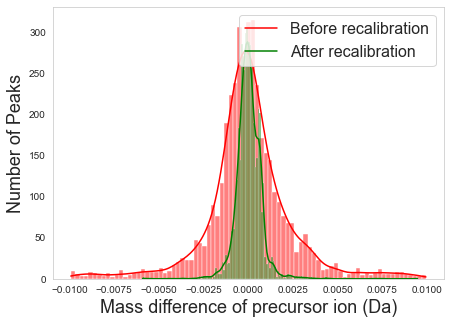

In [109]:
fig, ax = plt.subplots(
    figsize = (7, 5)
                      )
ax= sns.histplot(data=data_ead_r, x="diff_raw", multiple="stack", kde = True, color = "red")
ax = sns.histplot(data=data_ead_r, x="diff_recalibrated", multiple="stack", kde = True,color = "green")
# ax.set_title("Peak number difference after denoising", fontsize = 16)
ax.set_xlabel("Mass difference of precursor ion (Da)", fontsize = 18)
ax.set_ylabel("Number of Peaks", fontsize = 18)
ax.grid(False)
plt.legend(labels=["Before recalibration","After recalibration"], loc = 'upper right',fontsize=16)
plt.savefig('data/recalibration.tiff', dpi = 300,facecolor = 'white', edgecolor = 'white')

In [107]:
data_ead_unique = data_ead_r.drop_duplicates(subset=['key'])

In [113]:
len(data_ead)-len(data_ead['key'].unique())

860

In [137]:
data_temp=data_ead_r.loc[data_ead_r['key']=='YPIGGYHFMKJNKV-UHFFFAOYSA-N[M+H]+']

In [138]:
msms_temp = (so.weighted_average_spectra(data_temp, typeofmsms='msms_recalibrated', ifnormalize=True))

In [139]:
msms_consensus = so.make_consensus_spectra(data_temp, typeofmsms='msms_recalibrated', ifnormalize=True)

In [132]:
data_temp

,NAME,key,PRECURSORMZ,InChIKey,Formula,ExactMass,Adduct,Spectrum_type,RETENTIONTIME,Average_mz,Comment,Alignment_ID,ms1,msms,Collision_energy,intensity,mix_label,Ion_mode,msms_recalibrated
0,2-METHOXYRESORCINOL,QFYYAIBEHOEZKC-UHFFFAOYSA-N[M+H]+,141.054625,QFYYAIBEHOEZKC-UHFFFAOYSA-N,C7H8O3,140.04734,[M+H]+,MS2,0.305,141.0544,1083EAD_PFP intensity 17095,1083,141.0544\t17095\n142.05775\t1816\n143.06111\t296,50.0162\t736\n51.02511\t1515\n52.03068\t706\n5...,None,17095,PFPpos_P N 32_EAD,P,50.016142\t736.0\n51.025053\t1515.0\n52.030624...


<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/matplotlib/pyplot.py'>

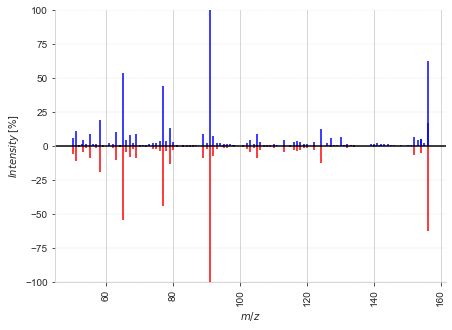

In [148]:
ms2plotter.head_to_tail_plot(data.iloc[1]['msms'],data.iloc[1]['msms_denoised'],ifnormalized=False)

In [109]:
consensus_msms = []
for key in tqdm(data_ead_unique['key'].unique()):
    data_temp =  data_ead_r.loc[data_ead_r['key']==key]
    consensus_msms.append(so.weighted_average_spectra(data_temp, typeofmsms='msms_recalibrated', ifnormalize=True))
data_ead_unique['msms']=consensus_msms
print("i am done processing the concensus spectra")
msms_consensus_denoised = []
for index, row in tqdm(data_ead_unique.iterrows(), total = data_ead_unique.shape[0]):
    # break
    try:
        msms_consensus_denoised.append(de.denoise_blacklist(row, typeofmsms='msms'))
    except:
        msms_consensus_denoised.append(row['msms'])
data_ead_unique['msms_denoised']=msms_consensus_denoised

100%|██████████| 3272/3272 [3:35:49<00:00,  3.96s/it]  


i am done processing the concensus spectra


100%|██████████| 3272/3272 [5:40:39<00:00,  6.25s/it]     


In [65]:
data_ead_unique.to_csv("data/EAD/EAD_library_unique_final.csv")

In [2]:
data = pd.read_csv("data/EAD/EAD_library_unique_final.csv")

In [110]:
explained_intensity = []
max_unassigned_intensity = []
for index, row in tqdm(data.iterrows(), total=len(data)):
    explained_intensity.append(so.explained_intensity(row['msms'], row['msms_denoised']))
    max_unassigned_intensity.append(so.max_unassigned_intensity(row['msms'], row['msms_denoised']))
data['explained_intensity']=explained_intensity
data['max_unassigned_intensity']=max_unassigned_intensity
evaluations = []
for index, row in tqdm(data.iterrows(), total=len(data)):
    if row['explained_intensity']<0.8 and row['max_unassigned_intensity']>0.2:
        evaluations.append('flagged: poor quality')
    elif row['explained_intensity']<0.8:
        evaluations.append('flagged:low assigned intensity')
    elif row['max_unassigned_intensity']>30:
        evaluations.append('flagged: high unassigned intensity')
    else:
        evaluations.append('good quality')
data['evaluations']=evaluations

100%|██████████| 3272/3272 [00:00<00:00, 59805.04it/s]


In [119]:
# data['Comment'] = data.apply(lambda row : row['Comment'].replace(str(row['evaluations']), ''), axis=1)
data['Comment']= data['Comment']+ ' '+data['evaluations']

In [121]:
data.head()

,Unnamed: 0,NAME,key,PRECURSORMZ,InChIKey,Formula,ExactMass,Adduct,Spectrum_type,RETENTIONTIME,...,Num_Peaks,msms,count,intensity,mix_label,Ion_mode,msms_denoised,explained_intensity,max_unassigned_intensity,evaluations
0,0,2-METHOXYRESORCINOL,QFYYAIBEHOEZKC-UHFFFAOYSA-N[M+H]+,141.054625,QFYYAIBEHOEZKC-UHFFFAOYSA-N,C7H8O3,140.04734,[M+H]+,MS2,0.305,...,98,50.016142\t21.643876\n51.025053\t44.552272\n52...,NaN,17095,PFPpos_P N 32_EAD,P,50.016142\t21.643876\n51.025053\t44.552272\n52...,0.953230,3.675929,good quality
1,1,Arecoline,HJJPJSXJAXAIPN-UHFFFAOYSA-N[M+H]+,156.101910,HJJPJSXJAXAIPN-UHFFFAOYSA-N,C8H13NO2,155.09463,[M+H]+,MS2,2.582,...,125,50.014812\t5.602716\n51.023723\t11.375212\n51....,NaN,19353,PFPpos_P N 32_EAD,P,50.014812\t5.602716\n51.023723\t11.375212\n52....,0.856726,17.147708,good quality
2,3,2-METHOXYRESORCINOL,QFYYAIBEHOEZKC-UHFFFAOYSA-N[M+Na]+,163.036565,QFYYAIBEHOEZKC-UHFFFAOYSA-N,C7H8O3,140.04734,[M+Na]+,MS2,2.276,...,27,105.037568\t0.11217\n115.049837\t0.514965\n117...,NaN,4983558,PFPpos_P N 32_EAD,P,105.037568\t0.11217\n115.049837\t0.514965\n119...,0.851347,11.038597,good quality
3,4,Arecoline,HJJPJSXJAXAIPN-UHFFFAOYSA-N[M+NH4]+,173.128450,HJJPJSXJAXAIPN-UHFFFAOYSA-N,C8H13NO2,155.09463,[M+NH4]+,MS2,2.237,...,25,104.804778\t1.551481\n113.038645\t1.551481\n11...,NaN,43595,PFPpos_P N 32_EAD,P,113.038645\t1.551481\n115.054412\t39.862994\n1...,0.765514,100.000000,flagged: poor quality
4,6,4-nitroquinoline 1-oxide,YHQDZJICGQWFHK-UHFFFAOYSA-N[M+H]+,191.045123,YHQDZJICGQWFHK-UHFFFAOYSA-N,C9H6N2O3,190.03784,[M+H]+,MS2,0.943,...,171,50.014112\t3.456174\n51.023013\t11.28983\n52.0...,NaN,1190323,PFPpos_P N 32_EAD,P,50.014112\t3.456174\n51.023013\t11.28983\n52.0...,0.976715,1.364145,good quality


In [122]:
so.export_library(data, 'data/EAD/EAD_HILIC_PFP_Com.txt', typeofmsms='msms_denoised')

In [123]:
data.to_csv("data/EAD/EAD_HILIC_PFP_Com.csv", index = False)

In [83]:
data = pd.read_csv("~/Documents/GitHub/Libgen_data/EAD/EAD_HILIC_PFP_Com.csv")

In [93]:
normalized_entropy =[]
normalized_entroy_denoised = []
for index, row in data.iterrows():
    normalized_entropy.append(so.normalized_entropy(row['msms']))
    normalized_entroy_denoised.append(so.normalized_entropy(row['msms_denoised']))

In [94]:
data['normalized_entropy'] = normalized_entropy
data['normalized_entroy_denoised']=normalized_entroy_denoised

In [95]:
data['normalized_entropy'].describe()

count    3272.000000
mean        0.328361
std         0.158072
min         0.001662
25%         0.206104
50%         0.321660
75%         0.433727
max         0.833134
Name: normalized_entropy, dtype: float64

In [115]:
len(data.loc[data['normalized_entroy_denoised']<0.8])

3256

In [116]:
len(data)

3272

In [117]:
3256/3272

0.9951100244498777

In [92]:
so.normalized_entropy(data.iloc[0]['msms_denoised'])

7.257496462999534e-09

In [159]:
so.convert_string_to_nist(data.iloc[0]['msms_denoised'])

array([[ 50.016144,  21.643875],
       [ 51.02505 ,  44.552273],
       [ 52.030624,  20.761654],
       [ 53.04243 ,  85.45802 ],
       [ 54.009975,   0.588149],
       [ 54.045975,   0.91163 ],
       [ 55.018227,  13.703868],
       [ 56.062946,   0.558741],
       [ 57.0346  ,   2.529039],
       [ 60.98173 ,   1.02926 ],
       [ 61.01004 ,   0.646963],
       [ 63.012592,   1.85267 ],
       [ 63.0227  ,   3.352449],
       [ 64.03149 ,   2.440817],
       [ 65.038   ,  29.936773],
       [ 66.04681 ,   2.734892],
       [ 67.05293 ,   7.057786],
       [ 68.02304 ,   0.529333],
       [ 68.99644 ,   1.676225],
       [ 69.03184 ,   4.117042],
       [ 70.04152 ,   0.882224],
       [ 71.01311 ,   0.499927],
       [ 74.016075,   0.617557],
       [ 75.00457 ,   0.588149],
       [ 75.01985 ,   1.14689 ],
       [ 76.02867 ,   2.205558],
       [ 77.039085,  24.349361],
       [ 78.03194 ,   0.499927],
       [ 78.04838 ,   1.676223],
       [ 79.01546 ,   2.88193 ],
       [ 7

In [160]:
so.convert_string_to_nist(data.iloc[0]['msms'])

array([[ 50.016144,  21.643875],
       [ 51.02505 ,  44.552273],
       [ 52.030624,  20.761654],
       [ 53.04243 ,  85.45802 ],
       [ 53.484264,   1.117482],
       [ 53.604694,   1.264521],
       [ 53.670696,   1.293927],
       [ 53.838043,   0.91163 ],
       [ 54.009975,   0.588149],
       [ 54.045975,   0.91163 ],
       [ 55.018227,  13.703868],
       [ 55.469666,   0.529333],
       [ 56.062946,   0.558741],
       [ 57.0346  ,   2.529039],
       [ 57.93404 ,   0.529333],
       [ 60.98173 ,   1.02926 ],
       [ 61.01004 ,   0.646963],
       [ 63.012592,   1.85267 ],
       [ 63.0227  ,   3.352449],
       [ 64.03149 ,   2.440817],
       [ 65.038   ,  29.936773],
       [ 66.04681 ,   2.734892],
       [ 67.05293 ,   7.057786],
       [ 68.02304 ,   0.529333],
       [ 68.99644 ,   1.676225],
       [ 69.03184 ,   4.117042],
       [ 70.04152 ,   0.882224],
       [ 71.01311 ,   0.499927],
       [ 71.98973 ,   1.323335],
       [ 72.93704 ,   1.205704],
       [ 7

<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/matplotlib/pyplot.py'>

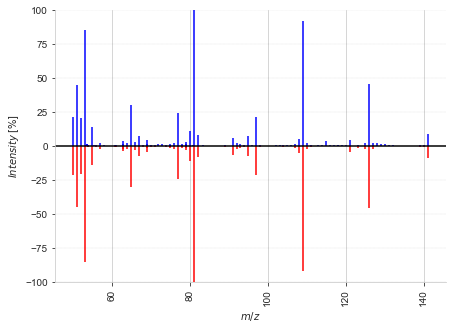

In [158]:
ms2plotter.head_to_tail_plot(data.iloc[0]['msms'], data.iloc[0]['msms_denoised'], ifnormalized=False)

In [106]:
data.columns

Index(['Unnamed: 0', 'NAME', 'key', 'PRECURSORMZ', 'InChIKey', 'Formula',
       'ExactMass', 'Adduct', 'Spectrum_type', 'RETENTIONTIME', 'Average_mz',
       'Comment', 'Alignment_ID', 'Num_Peaks', 'msms', 'count', 'intensity',
       'mix_label', 'Ion_mode', 'msms_denoised', 'explained_intensity',
       'max_unassigned_intensity', 'evaluations', 'normalized_entropy',
       'normalized_entroy_denoised'],
      dtype='object')

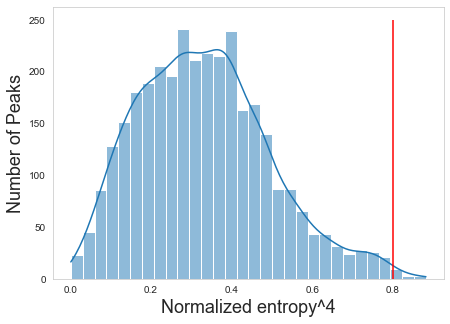

In [124]:
fig, ax = plt.subplots(
    figsize = (7, 5)
                      )
ax= sns.histplot(data=data, x="normalized_entroy_denoised", multiple="stack", kde = True,
                 # hue="evaluations"
                 )
# ax.yaxis
plt.vlines(x =0.8, ymin = 0, ymax=250,colors='red')
# ax = sns.histplot(data=data_ead_r, x="diff_recalibrated", multiple="stack", kde = True,color = "green")
# ax.set_title("Peak number difference after denoising", fontsize = 16)
ax.set_xlabel("Normalized entropy^4", fontsize = 18)
ax.set_ylabel("Number of Peaks", fontsize = 18)
ax.grid(False)
# plt.legend(labels=["Before recalibration","After recalibration"], loc = 'upper right')
plt.savefig('data/normalized_entropy.tiff', dpi = 300,facecolor = 'white', edgecolor = 'white')

In [125]:
data.head()

,Unnamed: 0,NAME,key,PRECURSORMZ,InChIKey,Formula,ExactMass,Adduct,Spectrum_type,RETENTIONTIME,...,count,intensity,mix_label,Ion_mode,msms_denoised,explained_intensity,max_unassigned_intensity,evaluations,normalized_entropy,normalized_entroy_denoised
0,0,2-METHOXYRESORCINOL,QFYYAIBEHOEZKC-UHFFFAOYSA-N[M+H]+,141.054625,QFYYAIBEHOEZKC-UHFFFAOYSA-N,C7H8O3,140.04734,[M+H]+,MS2,0.305,...,NaN,17095,PFPpos_P N 32_EAD,P,50.016142\t21.643876\n51.025053\t44.552272\n52...,0.953230,3.675929,good quality,0.224414,0.262197
1,1,Arecoline,HJJPJSXJAXAIPN-UHFFFAOYSA-N[M+H]+,156.101910,HJJPJSXJAXAIPN-UHFFFAOYSA-N,C8H13NO2,155.09463,[M+H]+,MS2,2.582,...,NaN,19353,PFPpos_P N 32_EAD,P,50.014812\t5.602716\n51.023723\t11.375212\n52....,0.856726,17.147708,good quality,0.294759,0.262583
2,3,2-METHOXYRESORCINOL,QFYYAIBEHOEZKC-UHFFFAOYSA-N[M+Na]+,163.036565,QFYYAIBEHOEZKC-UHFFFAOYSA-N,C7H8O3,140.04734,[M+Na]+,MS2,2.276,...,NaN,4983558,PFPpos_P N 32_EAD,P,105.037568\t0.11217\n115.049837\t0.514965\n119...,0.851347,11.038597,good quality,0.028564,0.011353
3,4,Arecoline,HJJPJSXJAXAIPN-UHFFFAOYSA-N[M+NH4]+,173.128450,HJJPJSXJAXAIPN-UHFFFAOYSA-N,C8H13NO2,155.09463,[M+NH4]+,MS2,2.237,...,NaN,43595,PFPpos_P N 32_EAD,P,113.038645\t1.551481\n115.054412\t39.862994\n1...,0.765514,100.000000,flagged: poor quality,0.493899,0.559890
4,6,4-nitroquinoline 1-oxide,YHQDZJICGQWFHK-UHFFFAOYSA-N[M+H]+,191.045123,YHQDZJICGQWFHK-UHFFFAOYSA-N,C9H6N2O3,190.03784,[M+H]+,MS2,0.943,...,NaN,1190323,PFPpos_P N 32_EAD,P,50.014112\t3.456174\n51.023013\t11.28983\n52.0...,0.976715,1.364145,good quality,0.148123,0.211773


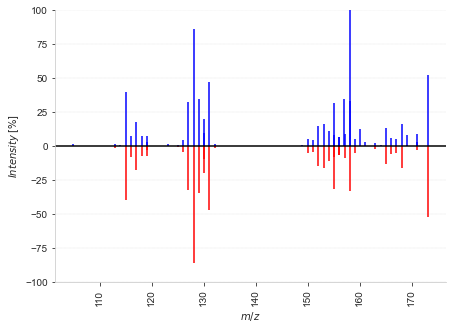

In [132]:
ms2plotter.head_to_tail_plot(data.iloc[3]['msms'], data.iloc[3]['msms_denoised'],identity=True)
ax.grid(False)
plt.savefig('data/bad_example.tiff', dpi = 300,facecolor = 'white', edgecolor = 'white')

In [111]:
len(data['key'])

3272

In [100]:
(data['explained_intensity']).describe()

count    3272.000000
mean        0.896940
std         0.140557
min         0.031619
25%         0.863195
50%         0.951403
75%         0.983929
max         1.000000
Name: explained_intensity, dtype: float64

In [ ]:
(data['max_unassigned_intensity']>30).sum()

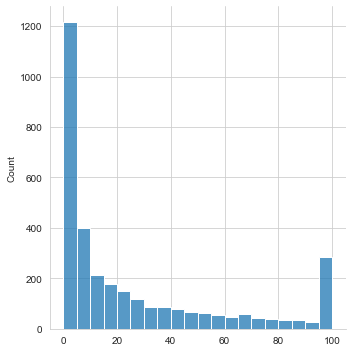

In [92]:
sns.displot(max_unassigned_intensity)

1.308374

In [33]:
len(index)

1

In [36]:
key = data_ead['key'].unique()[1]
data_temp = data_ead.loc[data_ead['key']==key]

In [ ]:
data

# under development

In [6]:
instance = data_ead_r.iloc[0]

In [31]:
# msms1 = so.normalize_spectra(instance['msms_recalibrated'])
# msms2=so.normalize_spectra(de.denoise_blacklist_msms(instance['msms_recalibrated'], instance['PRECURSORMZ'], instance['Adduct'],
#                                             instance['Formula'], mass_error=0.01, ppm=False))

In [ ]:
# def evaluate_spectra(msm1, msms2):
#     mass_raw, intensity_raw = break_spectra(msms1)
#     mass_dr, intensity_dr = break_spectra(msms2)
#     ifsum(intensity_de)/sum(intensity_raw)
#     diff_index = [i for i, item in enumerate(mass_raw_fl) if item not in set(mass_dr_fl)]
#     mass_diff = list(itemgetter(*diff_index)(mass_raw))
#     intensity_diff = list(itemgetter(*diff_index)(intensity_raw))
#     rel_intensity_diff = [number / max([float(x) for x in intensity_raw])*100 for number in [float(y) for y in intensity_diff]]
#     rel_intensity_kept = [number / max([float(x) for x in intensity_raw])*100 for number in [float(y) for y in intensity_dr]]
#     return(mass_diff,rel_intensity_diff,rel_intensity_kept)


In [126]:
assigned_intensity =[]
msms_denoised = []
for index, row in data_ead.iterrows():
consensus_raw_d = de.denoise_blacklist_msms(instance['msms_recalibrated'], instance['PRECURSORMZ'], instance['Adduct'],
                                            instance['Formula'], mass_error=0.01, ifppm=False)
mass_d, intensity_d = so.break_spectra(consensus_raw_d)
mass, intensity = so.break_spectra(instance['msms_recalibrated'])
sum(intensity_d)/sum(intensity)

0.9844367796752755

In [114]:
mass_d

[50.014606,
 51.023517,
 52.028357,
 52.938888,
 53.038718,
 54.034319,
 55.05443,
 56.941282,
 57.069242,
 58.064473,
 59.047974,
 60.983136,
 62.014097,
 63.023358,
 64.017249,
 64.030579,
 65.03788,
 66.044291,
 67.054421,
 68.048772,
 68.994283,
 70.064354,
 70.956045,
 72.043656,
 74.015118,
 75.014649,
 75.021429,
 76.03113,
 77.038121,
 78.034422,
 78.041342,
 79.052803,
 80.049734,
 80.055864,
 81.032634,
 81.061735,
 81.068785,
 83.048546,
 83.083376,
 84.079277,
 85.007928,
 86.016179,
 89.039592,
 90.040723,
 91.055864,
 92.057895,
 93.065406,
 94.060347,
 95.053898,
 95.081598,
 95.951878,
 96.080508,
 98.09885,
 101.038133,
 102.037104,
 102.046994,
 103.055895,
 104.048776,
 104.055776,
 105.043407,
 105.070517,
 106.068998,
 107.084359,
 108.06892,
 109.073331,
 110.022771,
 110.072102,
 110.993882,
 113.000954,
 115.055436,
 116.057957,
 117.061648,
 118.055819,
 118.066459,
 119.06167,
 119.07984,
 119.08733,
 120.079311,
 122.083193,
 122.097263,
 126.048306,
 127.054

In [104]:
sum(intensity_d)

8307.0

In [62]:
mass_d

[113.058104,
 115.052146,
 119.07329,
 121.103292,
 122.060323,
 124.074055,
 127.074187,
 128.058918,
 129.068599,
 130.997781,
 156.111394]

In [84]:
intensity

[45.0,
 51.0,
 11.0,
 26.0,
 256.0,
 1030.0,
 88.0,
 29.0,
 33.0,
 11.0,
 35.0,
 535.0,
 96.0,
 719.0,
 27.0,
 54.0,
 2048.0,
 8123.0]

In [87]:
nl_candidates = mtf.nl_to_formula(pep_mass - 154.086182, 0.02, 'C8H13NO2')

In [96]:
nl_candidates[0]

'H2'

In [95]:
from molmass import Formula

In [98]:
len(Formula(nl_candidates[0]).composition())

1

In [97]:
Formula(nl_candidates[0]).composition()

(('H', 2, 2.015882, 1.0),)

In [99]:
for nl in nl_candidates:
    print(de.evaluate_nl_blacklist(nl))

True


In [89]:
mass_d

[113.058104,
 115.052146,
 119.07329,
 121.103292,
 122.060323,
 124.074055,
 127.074187,
 128.058918,
 129.068599,
 130.997781,
 156.111394]

In [63]:
mass-154.086182

TypeError: unsupported operand type(s) for -: 'list' and 'float'

In [54]:
intensity

[45.0,
 51.0,
 11.0,
 26.0,
 256.0,
 1030.0,
 88.0,
 29.0,
 33.0,
 11.0,
 35.0,
 535.0,
 96.0,
 719.0,
 27.0,
 54.0,
 2048.0,
 8123.0]

In [49]:
mass_d

[113.058104,
 115.052146,
 119.07329,
 121.103292,
 122.060323,
 124.074055,
 127.074187,
 129.068599,
 130.997781,
 156.111394]

In [52]:
sum(intensity_d)/sum(intensity)

0.7319361428463342

In [50]:
mass, intensity = so.break_spectra(data_subset.iloc[1]['msms_recalibrated'])

In [51]:
sum(intensity)

13217.0

In [24]:
sum(intensity_d)

1158.0

In [31]:
# msms_com = []
mass_com = []
intensity_com = []
ms1_intensity_com =[]
for index, row in data_subset.iterrows():
    msms_bin_temp = so.bin_spectra(row['msms_recalibrated'],156.10191, tolerance=10,ifnormalize=True, ppm =True)
    mass_temp, intensity_temp = so.break_spectra(msms_bin_temp)
    mass_com.extend(mass_temp)
    intensity_com.extend(intensity_temp)
    ms1_intensity_com.extend([row['intensity']]*len(mass_temp))
bin_left = pd.DataFrame({'mass': mass_com, 'intensity': intensity_com, 'ms1_intensity':ms1_intensity_com})

In [88]:
data_subse

,NAME,key,PRECURSORMZ,InChIKey,Formula,ExactMass,Adduct,Spectrum_type,RETENTIONTIME,Average_mz,Comment,Alignment_ID,Num_Peaks,msms,count,intensity,mix_label,Ion_mode,msms_recalibrated
1,Arecoline,HJJPJSXJAXAIPN-UHFFFAOYSA-N[M+H]+,156.10191,HJJPJSXJAXAIPN-UHFFFAOYSA-N,C8H13NO2,155.09463,[M+H]+,MS2,2.582,156.10075,1695EAD_PFP intensity 19353,1695,125,50.01487\t66\n51.02378\t134\n51.93963\t8\n52.0...,NaN,19353,PFPpos_P N 32_EAD,P,50.014606\t66.0\n51.023517\t134.0\n51.939367\t...
2,Arecoline,HJJPJSXJAXAIPN-UHFFFAOYSA-N[M+H]+,156.10191,HJJPJSXJAXAIPN-UHFFFAOYSA-N,C8H13NO2,155.09463,[M+H]+,MS2,0.136,156.10204,1699EAD_PFP intensity 3035366,1699,18,113.05831\t45\n115.05235\t51\n119.07349\t11\n1...,NaN,3035366,PFPpos_P N 32_EAD,P,113.058104\t45.0\n115.052146\t51.0\n119.07329\...


In [104]:
so.convert_string_to_nist(so.weighted_average_spectra(data_subset, 'msms_recalibrated', tolerance=10, ifnormalize=True, ppm = True))

array([[5.00146065e+01, 5.60271597e+00],
       [5.10235176e+01, 1.13752117e+01],
       [5.19393654e+01, 6.79117024e-01],
       [5.20283585e+01, 9.33785975e-01],
       [5.29388885e+01, 1.35823405e+00],
       [5.30387192e+01, 4.07470322e+00],
       [5.40343208e+01, 1.18845499e+00],
       [5.50544281e+01, 8.82852268e+00],
       [5.59337921e+01, 1.52801394e+00],
       [5.69412804e+01, 6.79117024e-01],
       [5.70692406e+01, 1.61290300e+00],
       [5.80644722e+01, 1.91001701e+01],
       [5.90479736e+01, 6.79117024e-01],
       [6.09831352e+01, 2.54668903e+00],
       [6.20140953e+01, 1.52801394e+00],
       [6.30233574e+01, 1.01867571e+01],
       [6.40172501e+01, 5.09338021e-01],
       [6.40305786e+01, 5.94228029e-01],
       [6.50378799e+01, 5.40747032e+01],
       [6.60442886e+01, 4.75381994e+00],
       [6.70544205e+01, 7.89473677e+00],
       [6.79356842e+01, 5.94228029e-01],
       [6.80487747e+01, 1.86757195e+00],
       [6.89942856e+01, 8.65874386e+00],
       [7.006435

In [95]:
bin, bin_left = so.make_bin(bin_left, 0.004)

In [96]:
bin

,mass,intensity,ms1_intensity
91,128.060168,13.752122,19353
131,128.058918,0.357011,3035366


In [97]:
sum =bin['ms1_intensity'].unique().sum()

In [99]:
temp_mass = bin['mass']*bin['ms1_intensity']/sum

In [101]:
temp_mass.sum()

128.05892591930453

In [83]:
sum

19353

In [84]:
temp_mass = bin['mass']*bin['ms1_intensity']/sum

In [86]:
temp_intensity =bin['intensity']*bin['ms1_intensity']/sum

In [87]:
temp_intensity

11    19.10017
dtype: float64

In [65]:
bin['ms1_intensity'].sum()

3054719

In [69]:
bin['ms1_intensity'].unique().sum()

3054719

In [74]:
115.055436*(19353/3054719)

0.728927227973506

In [70]:
test = bin['mass']*bin['ms1_intensity']/bin['ms1_intensity'].unique().sum()

In [75]:
test

77       0.728927
125    114.323240
dtype: float64

In [66]:

mass_consensus =[]
intensity_consensus = []
if len(bin)>1:
    sum =bin['ms1_intensity'].unique().sum()
    temp_mass = bin['mass']*bin['ms1_intensity']/sum
    temp_intensity =bin['intensity']*bin['ms1_intensity']/sum
    mass_consensus.append(temp_mass)
    intensity_consensus.append(temp_intensity)


NameError: name 'cofactor' is not defined

In [ ]:
msms_denoised = []
for i in tqdm(range(0, len(data_ead))):
    instance = data_ead.iloc[i]
    try:
        msms_d = de.denoise_blacklist(instance, typeofmsms = 'msms_recalibrated',mass_error_ppm=10)
        msms_denoised.append(msms_d)

    except:
        msms_denoised.append(np.NAN)

 38%|███▊      | 1454/3858 [3:56:13<1:38:55,  2.47s/it]   

In [3]:
data_ead.head()

NameError: name 'data_ead' is not defined

In [79]:
data_ead['msms_denoised'] =msms_denoised

3866

In [84]:
data_ead = data_ead.dropna(subset=['msms_denoised'])

In [85]:
data_ead.shape

(3862, 18)

In [86]:
# data_ead['msms_denoised'] =msms_denoised
Num_Peaks_denoised = []
for i in tqdm(range(0, len(data_ead))):
    Num_Peaks_denoised.append(so.num_peaks(data_ead.iloc[i]['msms_denoised']))

100%|██████████| 3862/3862 [00:00<00:00, 9443.30it/s]


In [87]:
data_ead['Num_Peaks_denoised']=Num_Peaks_denoised

In [88]:
data_ead['Num_Peaks_denoised'].describe()

count    3862.000000
mean      193.740549
std       127.034517
min         1.000000
25%       102.000000
50%       170.000000
75%       255.000000
max      1462.000000
Name: Num_Peaks_denoised, dtype: float64

In [89]:
data_ead['Num_Peaks'].describe()

count    3862.000000
mean      216.904454
std       136.740558
min         5.000000
25%       118.000000
50%       194.000000
75%       280.000000
max      1554.000000
Name: Num_Peaks, dtype: float64

In [96]:
mass_remove, intensity_remove, intensity_kept = so.comparing_spectrum(data_ead.iloc[1]['msms'], data_ead.iloc[1]['msms_denoised'])

In [97]:
so.break_spectra(data_ead.iloc[1]['msms'])

([50.01487,
  51.02378,
  51.93963,
  52.02862,
  52.93915,
  53.03898,
  54.03458,
  55.05469,
  55.93405,
  56.94154,
  57.0695,
  58.06473,
  59.04823,
  60.98339,
  62.01435,
  63.02361,
  64.0175,
  64.03083,
  65.03813,
  66.04454,
  67.05467,
  67.93593,
  68.04902,
  68.99453,
  70.0646,
  70.95629,
  72.0439,
  72.93634,
  74.01536,
  75.01489,
  75.02167,
  76.03137,
  77.03836,
  78.03466,
  78.04158,
  79.05304,
  80.04997,
  80.0561,
  81.03287,
  81.06197,
  81.06902,
  83.04878,
  83.08361,
  84.07951,
  85.00816,
  85.90923,
  86.01641,
  86.9438,
  89.03982,
  90.04095,
  91.05609,
  92.05812,
  93.06563,
  94.06057,
  95.05412,
  95.08182,
  95.9521,
  96.08073,
  96.93724,
  97.94873,
  98.09907,
  101.03835,
  102.03732,
  102.04721,
  103.05611,
  104.04899,
  104.05599,
  105.04362,
  105.07073,
  106.06921,
  107.08457,
  108.06913,
  109.07354,
  110.02298,
  110.07231,
  110.99409,
  113.00116,
  115.05564,
  116.05816,
  117.06185,
  118.05602,
  118.06666,
  

In [101]:
intensity_remove.extend(intensity_kept)

In [103]:
len(mass_remove)

32

In [104]:
len(intensity_remove)

125

In [106]:
data_ead.to_csv("data/EAD/EAD_lib_denoised.csv")